In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.special as spec
from scipy.stats import binom

%matplotlib inline
import my_graph # --OPTIONAL-- (for custom display and color codes), download it from the repository or REMOVE its call

In [2]:
###############################################
############# cortical parameters #############
###############################################


## ---- membrane parameters
Gl, Cm , El = 10e-9, 150e-12, -70e-3 
Ee, Ei = 0, -80e-3 # synaptic reversal potential
# integrate and fire properties
Vthre=-50e-3; refrac = 5e-3 ; 
## ---- excitatory synaptic conductances
Qe, Te = 1e-9, 5e-3
## ---- inhibitory synaptic conductances
Qi, Ti = 5e-9, 5e-3
Ntot = 10000

## ---- activated state parameters
fe_up, fi_up = 5, 9. # Hz, stationary activity levels
ge_up_mean, ge_up_var = 7e-9, 3e-9
gi_up_mean, gi_up_var = 20e-9, 8e-9
## ---- low conductance state parameters
fe_down, fi_down = 0.015, 0.1 # Hz, stationary activity levels

## ---- network parameters
pconnec = 0.05 # connection probability between neurons
g = 0.2 # 20 % of inhibitory neurons

###############################################
############# thalamic parameters #############
###############################################

########## thalamo-cortical afference
Qe_thal = 4*Qe # ~ 5*Qe_cort
Te_thal = Te # same for cortico-cortical and thalamo-cortical synapses
thal_connec = 0.02
Ntot_thal = 2000 # total neuron number, 1/10 the cortical one !!

# Analytical calculus

In [3]:
def PSP(t, Nsyn, Qsyn, Tsyn, Tm, Cm, E, mVm):
    """ function that give the PSP time course after the linearization of Kuhn et al. 2004,
    Equation 15 in the paper
    with also the case Tm=Tsyn (not discussed in the paper, but pretty trivial)"""
    if abs(Tm-Tsyn)>1e-10:
        A = Tsyn*Qsyn*Tm/(Cm*(Tm-Tsyn))*(E-mVm)
        psp = Nsyn*A*(np.exp(-t/Tm)-np.exp(-t/Tsyn))
    else:
        psp = Nsyn*Qsyn*t*(E-mVm)/Cm*np.exp(-t/Tm)
    return psp


def membrane_pot_fluct(fe, fi, Qe, Qi, Te, Ti, pconnec, Ntot, g):
    """ Kuhn et al. 2004 calculus of mean and variance of the Vm"""
    Fe, Fi = fe*pconnec*(1-g)*Ntot, fi*pconnec*g*Ntot
    muGe, muGi = Qe*Te*Fe, Qi*Ti*Fi
    muG = Gl+muGe+muGi
    muV = (muGe*Ee+muGi*Ei+Gl*El)/muG
    muGn, Tm = muG/Gl, Cm/muG
    
    Ue, Ui = Qe/muG*(Ee-muV), Qi/muG*(Ei-muV)

    sV = np.sqrt(Fe*(Ue*Te)**2/2./(Te+Tm)+Fi*(Qi*Ui)**2/2./(Ti+Tm))

    Fe, Fi = Fe+1e-9, Fi+1e-9 # just to insure a non zero division, 
    # Tv = ( Fe*(Ue*Te)**2 + Fi*(Qi*Ui)**2 ) /( Fe*(Ue*Te)**2/(Te+Tm) + Fi*(Qi*Ui)**2/(Ti+Tm) )

    return muV, sV+1e-12, Tm

def activation_prob(STIM, mVm, sVm, Vthre=Vthre):
    """ activation function of the network
    allows to calculate the recruitment as a response to STIM,
    Equation 11 in the paper"""
    numerator = spec.erf((Vthre-mVm)/(np.sqrt(2)*sVm)) - spec.erf((Vthre-mVm-STIM)/(np.sqrt(2)*sVm))
    denom = spec.erf((Vthre-mVm)/(np.sqrt(2)*sVm)) + 1
    return numerator/denom

def gaussian_func(vv, mVm, sVm):
    """ classic, Equation 4 in the paper"""
    return np.exp(-(vv-mVm)**2/2./sVm**2)/np.sqrt(2*np.pi)/sVm

def fraction_baseline_firing(mVm, sVm, Vthre=Vthre):
    """ number of neurons not available for the stimulus evoked response
    because they already fire due to the baseline firing rate
    this is equal to Nbg/Ntot in the paper"""
    return 0.5*(1-spec.erf((Vthre-mVm)/(np.sqrt(2)*sVm))) # 0 when Vthre>>0, 1 when Vthre<<0 

# Post-synaptic events (without recurrent amplification)

In [4]:
# we start by calculating the mean and variance of membrane potential in the cortical network
mVm_up_cort, sVm_up_cort, Tm_up_cort = membrane_pot_fluct(fe_up, fi_up, Qe, Qi, Te, Ti, pconnec, Ntot, g)
mVm_down_cort, sVm_down_cort, Tm_down_cort = membrane_pot_fluct(fe_down, fi_down, Qe, Qi, Te, Ti, pconnec, Ntot, g)

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


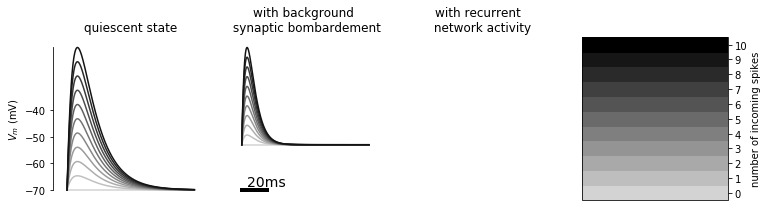

In [5]:
t = np.linspace(0, 100, 1e3)*1e-3

fig, ax = plt.subplots(1, 4, figsize=(12,3))
ax[0].set_title('quiescent state')
ax[1].set_title('with background \n synaptic bombardement')
ax[2].set_title('with recurrent \n network activity')
ax[0].plot([0,0], [-70,-35], 'wD', ms=0)
ax[1].plot([0,0], [-70,-35], 'wD', ms=0)
ax[2].plot([0,0], [-70,-35], 'wD', ms=0)
ax[1].plot([0, 20e-3], [-70,-70], 'k-', lw=4)
ax[1].annotate('20ms', (4e-3, -69), xycoords='data', fontsize=14)
colormap = my_graph.get_linear_colormap(color1='lightgray', color2='k')
array_of_thal_spikes = np.arange(12)
for i in range(len(array_of_thal_spikes)-1):
    PSP_up_cort = PSP(t, array_of_thal_spikes[i], Qe_thal, Te_thal, Tm_up_cort, Cm, Ee, mVm_up_cort)
    PSP_down_cort = PSP(t, array_of_thal_spikes[i], Qe_thal, Te_thal, Tm_down_cort, Cm, Ee, mVm_down_cort)
    cc = (array_of_thal_spikes[i]-array_of_thal_spikes.min())/(array_of_thal_spikes.max()-array_of_thal_spikes.min())
    ax[1].plot(t, 1e3*(PSP_up_cort+mVm_up_cort), color=colormap(cc,1))
    ax[0].plot(t, 1e3*(PSP_down_cort+mVm_down_cort), color=colormap(cc,1))
    
my_graph.build_bar_legend(array_of_thal_spikes, ax[-1], colormap,\
                          ticks_labels=array_of_thal_spikes,
                          label='number of incoming spikes')
   
my_graph.set_plot(ax[0], ['left'], xticks=[], ylabel='$V_m$ (mV)', yticks=[-70, -60, -50, -40])
my_graph.set_plot(ax[1], [], yticks=[], xticks=[])
my_graph.set_plot(ax[2], [], yticks=[], xticks=[])
# fig.savefig('fig2.svg')

# Spiking probability

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


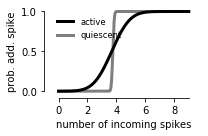

In [6]:
#### ACTIVATION functions in the 2 states (applies to the "available" neurons)

fig, ax = plt.subplots(figsize=(3,2))

## SAME WITH HIGHER DISCRETIZATION
array_of_thal_spikes = np.linspace(0, 9.,1e3)
max_depol_up_cort, max_depol_down_cort = [0.*array_of_thal_spikes for i in range(2)]
for i in range(len(array_of_thal_spikes)):
    PSP_up_cort = PSP(t, array_of_thal_spikes[i], Qe_thal, Te_thal, Tm_up_cort, Cm, Ee, mVm_up_cort)
    PSP_down_cort = PSP(t, array_of_thal_spikes[i], Qe_thal, Te_thal, Tm_down_cort, Cm, Ee, mVm_down_cort)
    max_depol_up_cort[i] = PSP_up_cort.max()
    max_depol_down_cort[i] = PSP_down_cort.max()
    
prob_up = activation_prob(max_depol_up_cort, mVm_up_cort, sVm_up_cort)
prob_down = activation_prob(max_depol_down_cort, mVm_down_cort, sVm_down_cort)

ax.plot(array_of_thal_spikes, prob_up, 'k-', lw=3, label="active")
ax.plot(array_of_thal_spikes, prob_down, 'k-', alpha=.5, lw=3, label="quiescent")
ax.legend(loc='upper left', prop={'size':'small'}, frameon=False)
my_graph.set_plot(ax, xlabel='number of incoming spikes', ylabel='prob. add. spike', ylim=[-0.02,1.02],\
         yticks=[0,0.5, 1], xticks=2*np.arange(5))
plt.tight_layout()
plt.savefig('/Users/yzerlaut/Desktop/fig.png')

In [ ]:
#### ACTIVATION functions in the 2 states (applies to the "available" neurons)

fig, ax = plt.subplots(figsize=(3,2))

## SAME WITH HIGHER DISCRETIZATION
array_of_thal_spikes = np.linspace(0, 9.,1e3)
max_depol_up_cort, max_depol_down_cort = [0.*array_of_thal_spikes for i in range(2)]
for i in range(len(array_of_thal_spikes)):
    PSP_up_cort = PSP(t, array_of_thal_spikes[i], Qe_thal, Te_thal, Tm_up_cort, Cm, Ee, mVm_up_cort)
    PSP_down_cort = PSP(t, array_of_thal_spikes[i], Qe_thal, Te_thal, Tm_down_cort, Cm, Ee, mVm_down_cort)
    max_depol_up_cort[i] = PSP_up_cort.max()
    max_depol_down_cort[i] = PSP_down_cort.max()
    
prob_up = activation_prob(max_depol_up_cort, mVm_up_cort, sVm_up_cort)
prob_down = activation_prob(max_depol_down_cort, mVm_down_cort, sVm_down_cort)

ax.plot(array_of_thal_spikes, prob_up, 'k-', lw=3, label="active")
ax.plot(array_of_thal_spikes, prob_down, 'k-', alpha=.5, lw=3, label="quiescent")
ax.legend(loc='upper left', prop={'size':'small'}, frameon=False)
my_graph.set_plot(ax, xlabel='number of incoming spikes', ylabel='prob. add. spike', ylim=[-0.02,1.02],\
         yticks=[0,0.5, 1], xticks=2*np.arange(5))
plt.tight_layout()
plt.savefig('/Users/yzerlaut/Desktop/fig.png')

# Feedforward arrangment of excitable networks

## For Vogels-Abbott config

In [7]:
###############################################
############# cortical parameters #############
###############################################


## ---- membrane parameters
Gl, Cm , El = 10e-9, 150e-12, -60e-3 
Ee, Ei = 0, -80e-3 # synaptic reversal potential
# integrate and fire properties
Vthre=-50e-3; refrac = 5e-3 ; 
## ---- excitatory synaptic conductances
Qe, Te = 7e-9, 5e-3
## ---- inhibitory synaptic conductances
Qi, Ti = 67e-9, 10e-3
Ntot = 10000

## ---- network parameters
pconnec = 0.02 # connection probability between neurons
g = 0.2 # 20 % of inhibitory neurons

## ---- activated state parameters
fe_up, fi_up = 24., 24. # Hz, stationary activity levels
## ---- low conductance state parameters
fe_down, fi_down = 0., 0.0 # Hz, stationary activity levels

###############################################
############# thalamic parameters #############
###############################################

########## thalamo-cortical afference
Qe_thal = 1e-9 # ~ 5*Qe_cort
Te_thal = 5e-3 # same for cortico-cortical and thalamo-cortical synapses
thal_connec = 0.02
Ntot_thal = 8000 # total neuron number, 1/10 the cortical one !!

-66.09446419502285 1.78638658179


/Users/yzerlaut/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


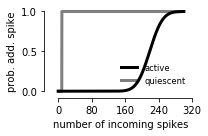

## For RS-FS config

In [24]:
###############################################
############# cortical parameters #############
###############################################


## ---- membrane parameters
Gl, Cm , El = 10e-9, 200e-12, -70e-3 
Ee, Ei = 0, -80e-3 # synaptic reversal potential
# integrate and fire properties
Vthre=-50e-3; refrac = 5e-3 ; 
## ---- excitatory synaptic conductances
Qe, Te = 1e-9, 5e-3
## ---- inhibitory synaptic conductances
Qi, Ti = 5e-9, 5e-3
Ntot = 5000

## ---- network parameters
pconnec = 0.05 # connection probability between neurons
g = 0.2 # 20 % of inhibitory neurons

## ---- activated state parameters
fe_up, fi_up = 5.+4., 10. # Hz, stationary activity levels
## ---- low conductance state parameters
fe_down, fi_down = 0., 0.0 # Hz, stationary activity levels

###############################################
############# thalamic parameters #############
###############################################

########## thalamo-cortical afference
Qe_thal = 2.5e-9 # ~ 5*Qe_cort
Te_thal = 5e-3 # same for cortico-cortical and thalamo-cortical synapses
thal_connec = 0.05
Ntot_thal = 4000 # total neuron number, 1/10 the cortical one !!

-53.96825396825396 2.41232782848


/Users/yzerlaut/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


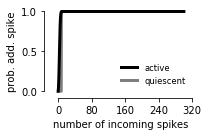

In [25]:
# we start by calculating the mean and variance of membrane potential in the cortical network
mVm_up_cort, sVm_up_cort, Tm_up_cort = membrane_pot_fluct(fe_up, fi_up, Qe, Qi, Te, Ti, pconnec, Ntot, g)
mVm_down_cort, sVm_down_cort, Tm_down_cort = membrane_pot_fluct(fe_down, fi_down, Qe, Qi, Te, Ti, pconnec, Ntot, g)
print(1e3*mVm_up_cort, 1e3*sVm_up_cort)
#### ACTIVATION functions in the 2 states (applies to the "available" neurons)

fig, ax = plt.subplots(figsize=(3,2))

## SAME WITH HIGHER DISCRETIZATION
array_of_thal_spikes = np.linspace(0, 300.,1e3)
max_depol_up_cort, max_depol_down_cort = [0.*array_of_thal_spikes for i in range(2)]
for i in range(len(array_of_thal_spikes)):
    PSP_up_cort = PSP(t, array_of_thal_spikes[i], Qe_thal, Te_thal, Tm_up_cort, Cm, Ee, mVm_up_cort)
    PSP_down_cort = PSP(t, array_of_thal_spikes[i], Qe_thal, Te_thal, Tm_down_cort, Cm, Ee, mVm_down_cort)
    max_depol_up_cort[i] = PSP_up_cort.max()
    max_depol_down_cort[i] = PSP_down_cort.max()
    
prob_up = activation_prob(max_depol_up_cort, mVm_up_cort, sVm_up_cort)
prob_down = activation_prob(max_depol_down_cort, mVm_down_cort, sVm_down_cort)

ax.plot(array_of_thal_spikes, prob_up, 'k-', lw=3, label="active")
ax.plot(array_of_thal_spikes, prob_down, 'k-', alpha=.5, lw=3, label="quiescent")
ax.legend(loc='lower right', prop={'size':'small'}, frameon=False)
my_graph.set_plot(ax, xlabel='number of incoming spikes', ylabel='prob. add. spike', ylim=[-0.02,1.02],\
         yticks=[0,0.5, 1])
plt.tight_layout()
plt.savefig('/Users/yzerlaut/Desktop/fig.png')
Resp_RS_FS = prob_up # storing for future comput
Resp_quiescent = prob_down

In [26]:
Area = 20000.*(1e-6)**2 # area
print('checking total capacitance with 1uF/cm2 :', Area*1e-2*1e12, 'pF')

checking total capacitance with 1uF/cm2 : 200.0 pF


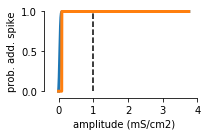

In [30]:
fig, ax = plt.subplots(figsize=(3,2))
X = array_of_thal_spikes*Qe_thal/Area*1e3/(1e2)**2 # for mS/cm2

ax.plot(X, Resp_RS_FS, lw=3, label="RS-FS")
ax.plot(X, Resp_quiescent, lw=3, label="Quiescent")
# ax.legend(loc='lower right', prop={'size':'small'}, frameon=False)
ax.plot([1,1], [0,1], 'k--')
my_graph.set_plot(ax, xlabel='amplitude (mS/cm2)', ylabel='prob. add. spike', ylim=[-0.02,1.02], yticks=[0,0.5, 1])
plt.tight_layout()
fig.savefig('/Users/yzerlaut/Desktop/fig.svg')

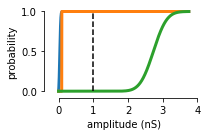

In [32]:
fig, ax = plt.subplots(figsize=(3,2))
X = array_of_thal_spikes*Qe_thal/Area*1e3/(1e2)**2 # for mS/cm2

ax.plot(X, Resp_RS_FS, lw=3, label="RS-FS")
ax.plot(X, Resp_quiescent, lw=3, label="Quiescent")
ax.plot(X, Resp_VA, lw=3, label="VA 2005")
# ax.legend(loc='lower right', prop={'size':'small'}, frameon=False)
ax.plot([1,1], [0,1], 'k--')
my_graph.set_plot(ax, xlabel='amplitude (nS)',ylabel='probability', ylim=[-0.02,1.02], yticks=[0,0.5, 1])
#my_graph.set_plot(ax, xlabel='amplitude (mS/cm2)', ylabel='prob. add. spike', ylim=[-0.02,1.02], yticks=[0,0.5, 1])
plt.tight_layout()
fig.savefig('/Users/yzerlaut/Desktop/fig2.svg')